# Warehouse Order Processing Simulation

This notebook simulates the processing of warehouse orders through three stages: checking, covering, and delivering. Orders arrive randomly, and employees perform tasks with limited capacity. The simulation tracks wait and service times at each stage and visualizes the results.

In [1]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt

## Configuration and Initialization

We set parameters for the number of employees at each stage, total simulation time, number of orders, and a random seed for reproducibility.

In [2]:
CHECK_EMPLOYEES = 2
COVER_EMPLOYEES = 2
DELIVER_EMPLOYEES = 2
SIM_TIME = 100
NUM_ORDERS = 50
RANDOM_SEED = 4232

random.seed(RANDOM_SEED)

## Warehouse Class

This class models the warehouse with resources (employees) for each processing stage. Each stage has an exponentially distributed service time.

In [3]:
class Warehouse:
    def __init__(self, env):
        self.env = env
        self.checkers = simpy.Resource(env, capacity=CHECK_EMPLOYEES)
        self.coverers = simpy.Resource(env, capacity=COVER_EMPLOYEES)
        self.deliverers = simpy.Resource(env, capacity=DELIVER_EMPLOYEES)

    def check_order(self, order_id):
        check_time = random.expovariate(1/5)
        yield self.env.timeout(check_time)

    def cover_order(self, order_id):
        cover_time = random.expovariate(1/6)
        yield self.env.timeout(cover_time)

    def deliver_order(self, order_id):
        deliver_time = random.expovariate(1/5)
        yield self.env.timeout(deliver_time)

## Order Process

Each order goes through the stages sequentially: check, cover, and deliver. Wait times and service times are recorded. Orders have an 80% chance of having items available; otherwise, the order is canceled.

In [4]:
def order_process(env, order_id, warehouse, stats):
    arrival_time = env.now
    print(f"[{arrival_time:.2f}] Order {order_id} arrived.")

    # Check Stage
    with warehouse.checkers.request() as request:
        check_queue_enter = env.now
        yield request
        check_wait = env.now - check_queue_enter
        print(f"[{env.now:.2f}] Order {order_id} checking started after waiting {check_wait:.2f}.")
        check_start = env.now
        yield env.process(warehouse.check_order(order_id))
        check_service = env.now - check_start

        # Randomly decide item availability (80% chance available)
        item_available = random.random() < 0.8
        if not item_available:
            print(f"[{env.now:.2f}] Order {order_id} cancelled (item unavailable).")
            stats['orders_cancelled'] += 1
            return
        print(f"[{env.now:.2f}] Order {order_id} passed checking.")

    # Cover Stage
    with warehouse.coverers.request() as request:
        cover_queue_enter = env.now
        yield request
        cover_wait = env.now - cover_queue_enter
        print(f"[{env.now:.2f}] Order {order_id} covering started after waiting {cover_wait:.2f}.")
        cover_start = env.now
        yield env.process(warehouse.cover_order(order_id))
        cover_service = env.now - cover_start
        print(f"[{env.now:.2f}] Order {order_id} covered.")

    # Deliver Stage
    with warehouse.deliverers.request() as request:
        deliver_queue_enter = env.now
        yield request
        deliver_wait = env.now - deliver_queue_enter
        print(f"[{env.now:.2f}] Order {order_id} delivering started after waiting {deliver_wait:.2f}.")
        deliver_start = env.now
        yield env.process(warehouse.deliver_order(order_id))
        deliver_service = env.now - deliver_start
        print(f"[{env.now:.2f}] Order {order_id} delivered.")

    total_time = env.now - arrival_time

    # Record stats
    stats['check_waits'].append(check_wait)
    stats['check_services'].append(check_service)
    stats['cover_waits'].append(cover_wait)
    stats['cover_services'].append(cover_service)
    stats['deliver_waits'].append(deliver_wait)
    stats['deliver_services'].append(deliver_service)
    stats['total_times'].append(total_time)
    stats['orders_completed'] += 1

## Order Generation

Orders arrive with inter-arrival times exponentially distributed.

In [5]:
def generate_orders(env, warehouse, stats):
    for i in range(NUM_ORDERS):
        yield env.timeout(random.expovariate(1/6))  # Inter-arrival time
        env.process(order_process(env, i, warehouse, stats))

## Run Simulation

We create the simulation environment, initialize the warehouse and statistics, then run the simulation for the configured time.

In [6]:
# Initialize statistics dict
stats = {
    'check_waits': [],
    'check_services': [],
    'cover_waits': [],
    'cover_services': [],
    'deliver_waits': [],
    'deliver_services': [],
    'total_times': [],
    'orders_completed': 0,
    'orders_cancelled': 0,
}

# Run simulation
env = simpy.Environment()
warehouse = Warehouse(env)
env.process(generate_orders(env, warehouse, stats))
env.run(until=SIM_TIME)

[3.56] Order 0 arrived.
[3.56] Order 0 checking started after waiting 0.00.
[6.33] Order 0 passed checking.
[6.33] Order 0 covering started after waiting 0.00.
[7.82] Order 0 covered.
[7.82] Order 0 delivering started after waiting 0.00.
[14.99] Order 1 arrived.
[14.99] Order 1 checking started after waiting 0.00.
[15.08] Order 2 arrived.
[15.08] Order 2 checking started after waiting 0.00.
[20.24] Order 2 passed checking.
[20.24] Order 2 covering started after waiting 0.00.
[20.52] Order 0 delivered.
[21.63] Order 2 covered.
[21.63] Order 2 delivering started after waiting 0.00.
[22.52] Order 1 passed checking.
[22.52] Order 1 covering started after waiting 0.00.
[24.50] Order 3 arrived.
[24.50] Order 3 checking started after waiting 0.00.
[26.79] Order 2 delivered.
[26.93] Order 1 covered.
[26.93] Order 1 delivering started after waiting 0.00.
[27.57] Order 4 arrived.
[27.57] Order 4 checking started after waiting 0.00.
[28.33] Order 3 passed checking.
[28.33] Order 3 covering starte

## Simulation Summary

Print mean, minimum, and maximum statistics of wait and service times and totals.

In [7]:
def print_stats(name, data):
    if len(data) > 0:
        print(f"{name}: mean={statistics.mean(data):.2f}, min={min(data):.2f}, max={max(data):.2f}")
    else:
        print(f"{name}: no data")

print("\n--- Simulation Summary ---")
print(f"Total orders completed: {stats['orders_completed']}")
print(f"Total orders cancelled: {stats['orders_cancelled']}")
print_stats("Check Wait Time", stats['check_waits'])
print_stats("Check Service Time", stats['check_services'])
print_stats("Cover Wait Time", stats['cover_waits'])
print_stats("Cover Service Time", stats['cover_services'])
print_stats("Deliver Wait Time", stats['deliver_waits'])
print_stats("Deliver Service Time", stats['deliver_services'])
print_stats("Total Time in System", stats['total_times'])


--- Simulation Summary ---
Total orders completed: 15
Total orders cancelled: 2
Check Wait Time: mean=0.92, min=0.00, max=4.78
Check Service Time: mean=4.65, min=0.02, max=11.56
Cover Wait Time: mean=0.87, min=0.00, max=4.36
Cover Service Time: mean=6.23, min=0.01, max=15.84
Deliver Wait Time: mean=0.21, min=0.00, max=3.21
Deliver Service Time: mean=6.08, min=0.93, max=13.85
Total Time in System: mean=18.96, min=8.22, max=42.40


## Plotting Results

Plot histograms for wait and service times of each stage and total times.

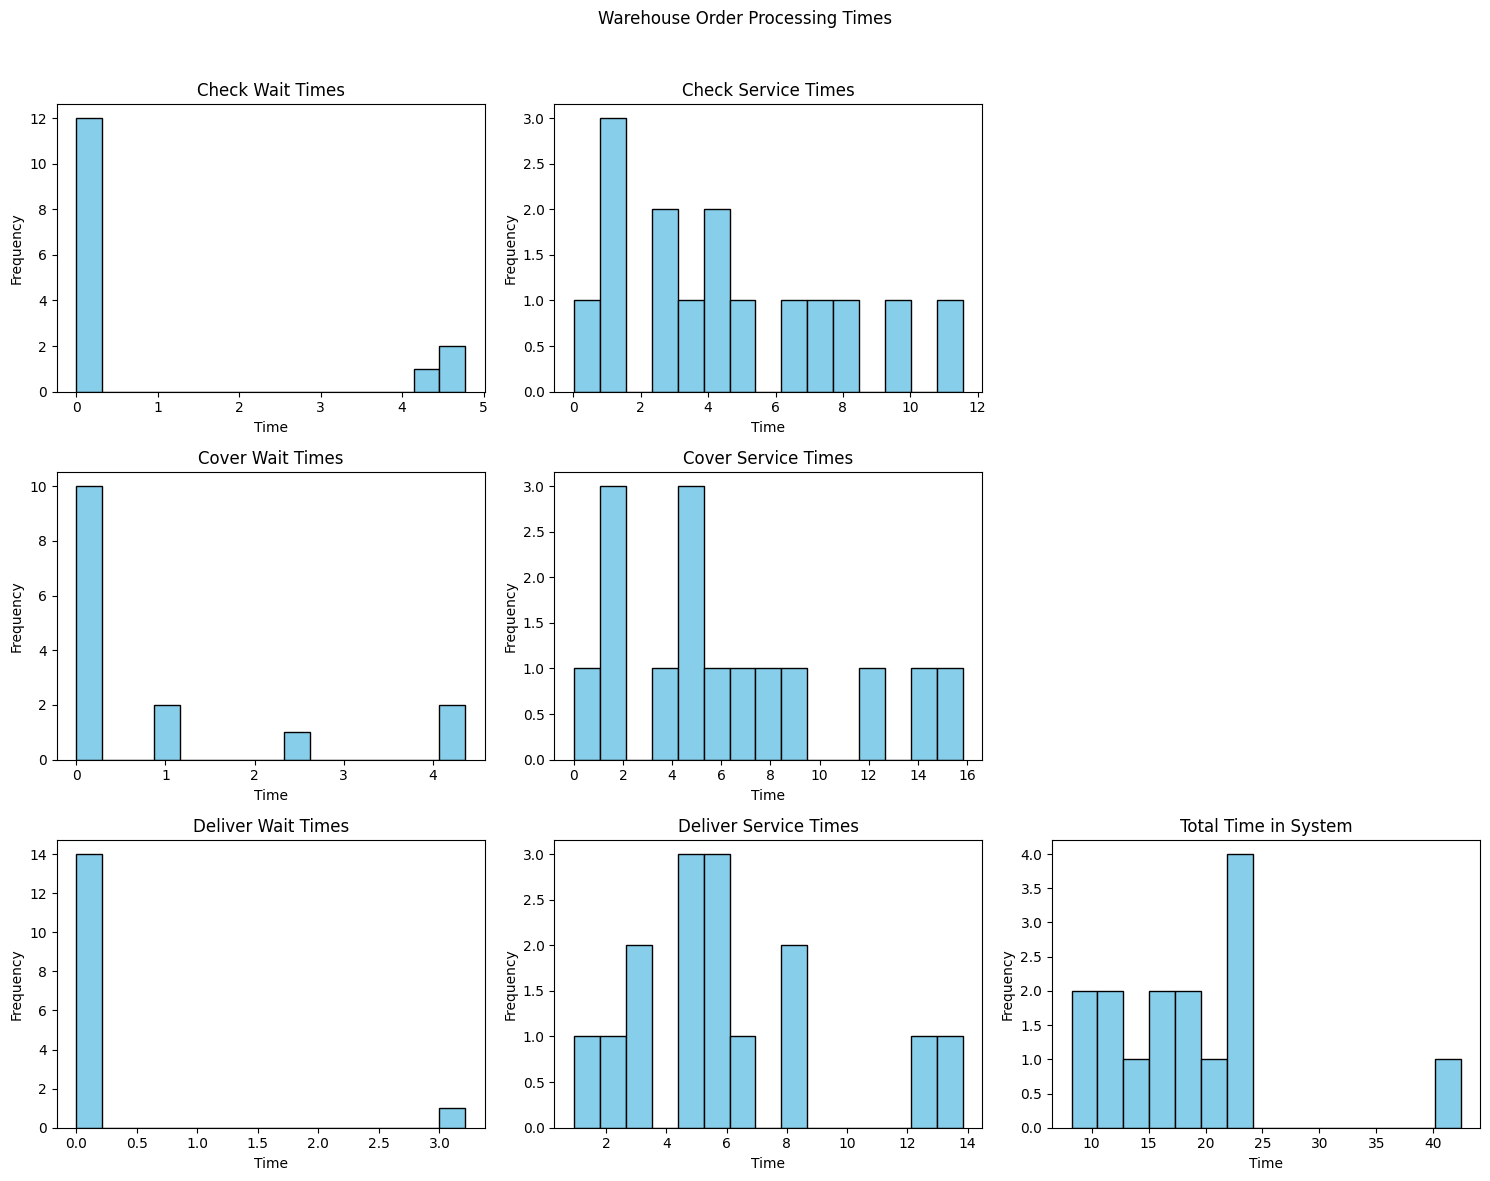

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Warehouse Order Processing Times')

def plot_hist(data, ax, title):
    ax.hist(data, bins=15, color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

plot_hist(stats['check_waits'], axs[0, 0], 'Check Wait Times')
plot_hist(stats['check_services'], axs[0, 1], 'Check Service Times')
axs[0, 2].axis('off')  # empty plot for symmetry

plot_hist(stats['cover_waits'], axs[1, 0], 'Cover Wait Times')
plot_hist(stats['cover_services'], axs[1, 1], 'Cover Service Times')
axs[1, 2].axis('off')

plot_hist(stats['deliver_waits'], axs[2, 0], 'Deliver Wait Times')
plot_hist(stats['deliver_services'], axs[2, 1], 'Deliver Service Times')
plot_hist(stats['total_times'], axs[2, 2], 'Total Time in System')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()